# Tweet Sentiment Classifier for BaceFook
Authors: John Sheehan & Tom Chapman

# Business Problem
We (Tall Guy Outreach, LLC) are customer satisfaction consultants retained by BaceFook to gauge the community’s reception to new functionality they are adding to their app. While BaceFook has great relationships with their largest enterprise customers, their app is used by individuals across the world. They need a reliable way to understand how individuals and small companies are responding to the new functionality without directly contacting each one.

Our understanding is that the development team feels their new features could be controversial. While the features are aimed at making the app more appealing to enterprise customers, there was some concern during the development process that additional options might overwhelm existing users. The company closely monitors new installs of their app, so the impact of new features on new users is something they feel they have a good handle on. As a result, we will limit our review to community response as a whole.

Currently, BaceFook pays contract employees to review their twitter mentions, record the tweets and label them based on the sentiment expressed within. This is a significant source of cost and inefficiency, since it requires a large team to keep up with the volume of mentions that follow a new version release.

We will use natural language processing on a tweet dataset in order to train our model to recognize emotion expressed in the tweets. Once BaceFook’s new functionality is released, we can feed new tweet information that mentions the app to our model and help the company understand how individuals are receiving the new functionality. With a strong enough classifier, the company should be able to reduce or eliminate its reliance on contract labor.


# Data Understanding
Our dataset includes 9,092 tweets about multiple brands and products. The tweets were labeled as positive, negative, neutral or not sure by contributors based on the sentiment that the user expressed about the product or products being discussed in the tweet. We elected to drop the 156 “not sure” tweets from our dataset since they accounted for less than 2% of the overall population. Most of the products being discussed are related to mobile devices and applications for those mobile devices, making the data well-suited for training a model on how users express sentiment for these types of products.

The data contains a significant class imbalance, with only 4.5% (411 tweets) classified as negative and only 33% (2,978 tweets) classified as positive. The remaining 62.5% (5,388 tweets) were neutral, which will require us to address class imbalance before running our models. In addition, the dataset is relatively small for a complex problem like sentiment analysis and may be unduly influenced by very active tweeters. 


In [1]:
# Package Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from PIL import Image
from pprint import pprint
import nltk
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import MaxNLocator
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk import FreqDist
from nltk import tokenize as tok
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, make_scorer, recall_score, accuracy_score, precision_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

#### Exploratory Data Analysis

In [2]:
# Read in the data & display .info()
df = pd.read_csv('./data/judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [3]:
# Visually inspect the dataset
df.head(5)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
# Dropped the sole blank tweet_text field
df.drop(index=[6], inplace=True)

In [5]:
# Count nulls in 'emotion directed at'
df['emotion_in_tweet_is_directed_at'].isna().sum()

5801

In [6]:
# Sample Tweet for Inspection
df["tweet_text"][6520]

"RT @mention RT @mention Can't be at #sxsw? download their free music mix on itunes {link} cc: @mention"

In [7]:
# Dropped the records where sentiment was labeled "I can't tell"
df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

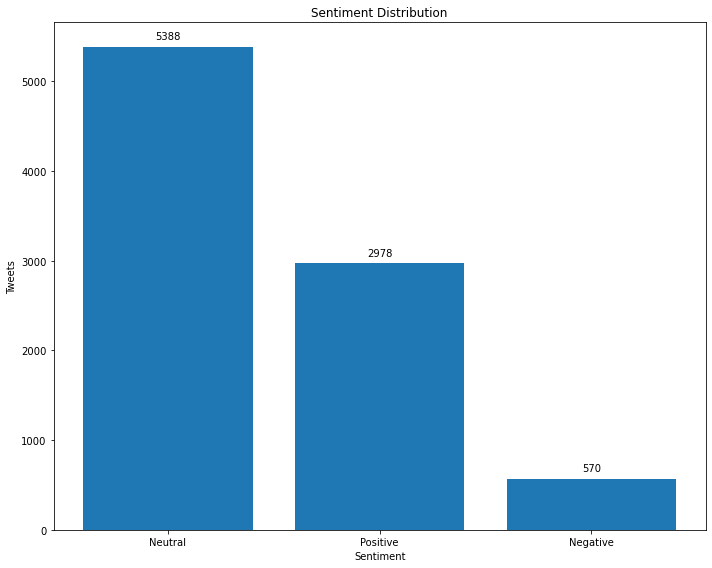

In [8]:
# Plot Target Class Distribution
tweet_dist = {'Neutral': 5388, 'Positive': 2978, 'Negative': 570}

fig, ax = plt.subplots(figsize=(10,8))
pps = plt.bar(tweet_dist.keys(), tweet_dist.values())
ax.set_title('Sentiment Distribution')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Tweets')


# Assign score values to each bar in the graph
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 5), # 3 points vertical offset
      textcoords="offset points",  
      ha='center', va='bottom')
    
plt.tight_layout(); 
plt.savefig('./images/sent_dist', facecolor='white', dpi=500)

#### Preprocessing Data
Effective natural language processing requires significant data modification and cleaning to allow the models to pick up on the meaning of the words they receive. In this section we will define several custom functions to assist with this process, as well as some custom regular expressions to help us filter out meaningless characters that are common in tweets (things like user handles, hashtags, and hyperlinks). We also lemmatized the data in order to avoid duplicate conjugations of words being treated differently by the code, and removed all punctuation.

Finally, we removed stop words from the data. Stop words are common words that appear so frequently in text as to not carry any syntactic meaning. English examples include “the”, “a”, “an”, etc. and were removed using nltk’s built-in stopwords list. There are also several words that appear frequently in each of our three target classes, and as such begin to lose their meaning when training a model. We discuss this further in the Most Common Words section.


In [9]:
# Create column for target variable for easier processing
df['target'] = df['is_there_an_emotion_directed_at_a_brand_or_product']

In [10]:
# Custom regular expressions utilized for cleaning tweet-specific features (retweets, user handles, etc.)
# Credit to Prajwal @ https://gitlab.com/praj88/twitter-analytics/blob/master/scripts/twitter-analytics.ipynb

# Identify hyperlinks in the subject data.
isURL = re.compile(r'http[s]?:// (?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', re.VERBOSE | re.IGNORECASE)

# Identify usernames in retweets.
isRTusername = re.compile(r'^RT+[\s]+(@[\w_]+:)',re.VERBOSE | re.IGNORECASE) #r'^RT+[\s]+(@[\w_]+:)'

# Identify entites preceded by the @ symbol (twitter handles).
isEntity = re.compile(r'@[\w_]+', re.VERBOSE | re.IGNORECASE)

In [11]:
# Function to remove URLs, retweeted usernames and usernames from tweet data.
def clean_tweet(row):
    row = isURL.sub("",row)
    row = isRTusername.sub("",row)
    row = isEntity.sub("",row)
    return row

In [12]:
# Created a new column by applying the clean_tweet function to the raw data.
df['clean'] = df['tweet_text'].apply(lambda row:clean_tweet(row))

In [13]:
# Create regular expression for identifying punctuation, and remove all punctuation in clean column.
RE_PUNCTUATION = '|'.join([re.escape(x) for x in string.punctuation])  
df['clean'] = df['clean'].str.replace(RE_PUNCTUATION, "")

In [14]:
# Instantiate a word net lemmatizer object and create helper function to apply it to the dataframe.
lemmatizer = WordNetLemmatizer()

def tokenize_lem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as its own token
    tokens = [word.lower() for sent in tok.sent_tokenize(text) for word in tok.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return [lemmatizer.lemmatize(token) for token in filtered_tokens]

In [15]:
# Apply the lemmatizer function to df.clean, lemmatizing the words and creating a list.
df['clean'] = df['clean'].apply(tokenize_lem)

In [16]:
# Create Stopwords list--standard wordlist plus commonly-seen words in the dataset.
sw = stopwords.words('english')
customsw = ['sxsw', 'link', 'rt', 'apple', 'austin', 'google', 'ipad', 'iphone', 'store', 'new', 'app', 'get', 'android']      
sw.extend(customsw)

In [17]:
# Helper function to remove stopwords
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in sw have been removed
    """
    stopwords_r = [token for token in token_list if token not in sw]
    return stopwords_r

In [18]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,target,clean
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Negative emotion,"[i, have, a, 3g, iphone, after, hr, tweeting, ..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Positive emotion,"[know, about, awesome, ipadiphone, app, that, ..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Positive emotion,"[can, not, wait, for, ipad, also, they, should..."
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Negative emotion,"[i, hope, this, year, festival, isnt, a, crash..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Positive emotion,"[great, stuff, on, fri, sxsw, marissa, mayer, ..."


In [19]:
# Apply the removal function to df.clean
df['clean'] = df['clean'].apply(remove_stopwords)

# create new column from df_clean that converts list of tokens to a string.
df['stop_r'] = df['clean'].str.join(" ")

In [20]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,target,clean,stop_r
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Negative emotion,"[3g, hr, tweeting, riseaustin, wa, dead, need,...",3g hr tweeting riseaustin wa dead need upgrade...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Positive emotion,"[know, awesome, ipadiphone, youll, likely, app...",know awesome ipadiphone youll likely appreciat...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Positive emotion,"[wait, also, sale]",wait also sale
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Negative emotion,"[hope, year, festival, isnt, crashy, year]",hope year festival isnt crashy year
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Positive emotion,"[great, stuff, fri, marissa, mayer, tim, oreil...",great stuff fri marissa mayer tim oreilly tech...


#### Most Common Words
In an effort to eliminate noise in our data from words that are common across all classes, we first grouped the data by target class and plotted visualizations of the most frequently-occuring words. When we found that a word appeared in the 10 most common words for each class, we added it to the list of stop words so that it was removed before the modeling process. In the end, we identified a list of 13 words that were so common among each class that they created confusion. These words fell into three distinct categories:
- Brand Names (apple, google, ipad, iphone, android)
- Location of the conference at which classification was performed (austin, sxsw)
- Common terms found in tweets or when referring to mobile applications (link, rt, store, new, app, get).

While meaningful individually, it is easy to understand how these words might lose value when they appear in tweets expressing opposing viewpoints. For example, in the sentences “I love taking pictures on my iphone at sxsw in Austin” and “I hate carrying a huge iphone all over Austin”, the words iphone and austin have very little to do with the type of emotion being expressed.

In [21]:
# Helper function to visualize the 10 most common words in each class.

def visualize_top_10(freq_dist, title):
    
    plt.rcParams.update({'font.size': 13})
    
    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    plt.tight_layout()
    
    # Save png of image to images folder using title as filename
    plt.savefig(f'./images/{title}', facecolor='white', dpi=500)

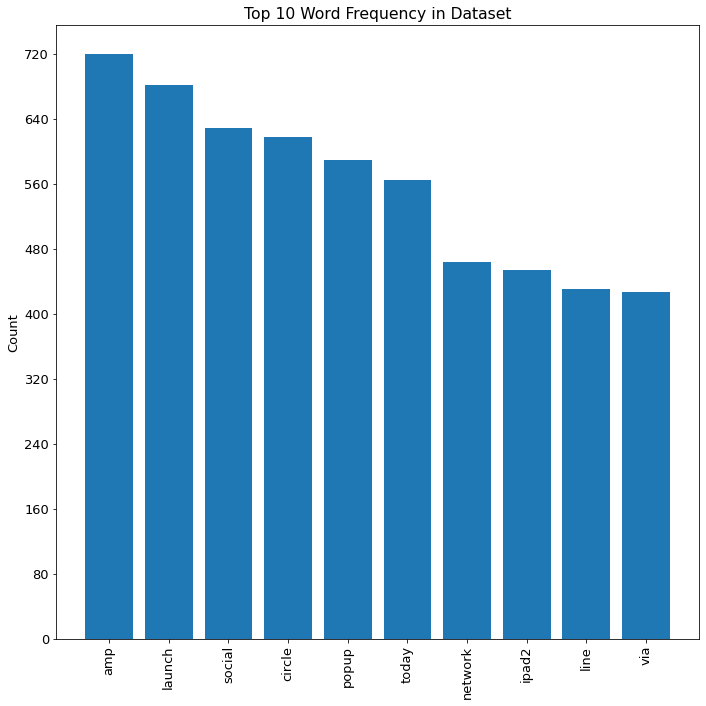

In [22]:
# Ten Most common words in the full dataset
sample_freq_dist = FreqDist(df["clean"].explode())
visualize_top_10(sample_freq_dist, "Top 10 Word Frequency in Dataset")

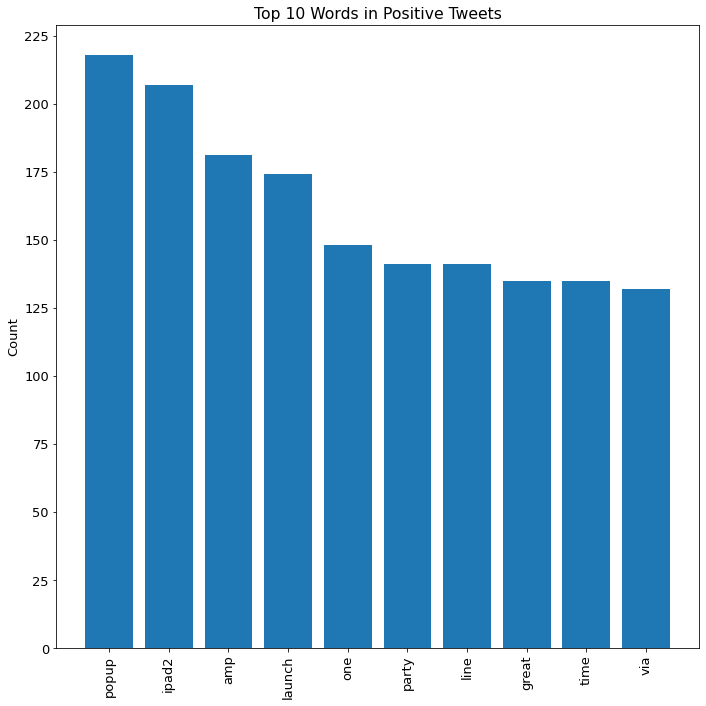

In [23]:
# Ten most common words appearing in positive tweets
pos_freq_dist = FreqDist(df['clean'].loc[df['target'] == 'Positive emotion'].explode())
visualize_top_10(pos_freq_dist, 'Top 10 Words in Positive Tweets')

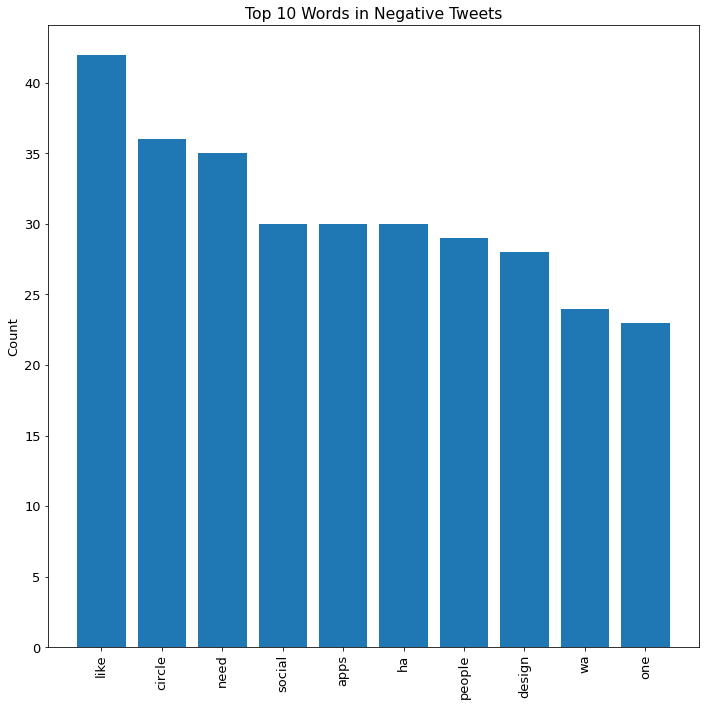

In [24]:
# Ten most common words appearing in negative tweets
neg_freq_dist = FreqDist(df['clean'].loc[df['target'] == 'Negative emotion'].explode())
visualize_top_10(neg_freq_dist, 'Top 10 Words in Negative Tweets')

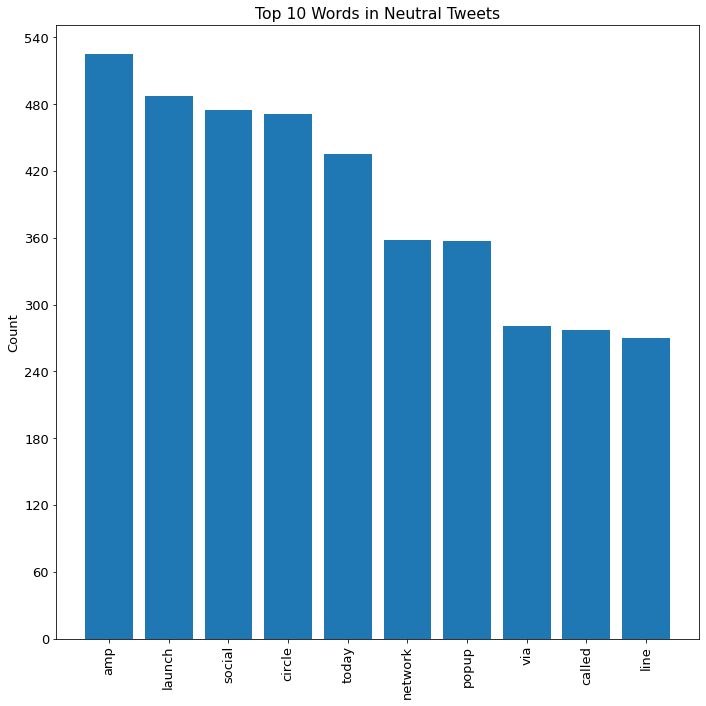

In [25]:
# Ten most common words appearing in neutral tweets
neut_freq_dist = FreqDist(df['clean'].loc[df['target'] == 'No emotion toward brand or product'].explode())
visualize_top_10(neut_freq_dist, 'Top 10 Words in Neutral Tweets')

In [26]:
#create a mask for all the word cloud shapes
mask = np.array(Image.open("./images/twitter_mask.png"))

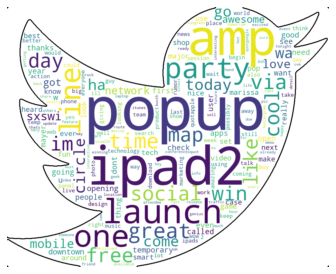

In [27]:
# Create wordcloud for positive tweets for presentation

pos_word = df['stop_r'].loc[df['target'] == 'Positive emotion']
pos_text=" ".join(row for row in pos_word)
pos_freq = {}
for i in pos_text.split():
    if i in pos_freq:
        pos_freq[i] += 1
    else:
        pos_freq[i] = 1
pos_wordcloud = WordCloud(collocations=False, mask=mask,contour_width=2, background_color='white', width=1200, height=800).generate_from_frequencies(pos_freq) 
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()

pos_wordcloud.to_file("./images/pos_cloud.png");

In [28]:
# Grab sample of a positive tweet
df.loc[df['target']== 'Positive emotion']['tweet_text'].iloc[3]

'#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan'

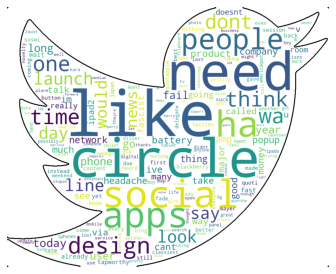

In [29]:
# Create wordcloud for negative tweets for presentation
neg_word = df['stop_r'].loc[df['target'] == 'Negative emotion']
neg_text=" ".join(row for row in neg_word)
neg_freq = {}
for i in neg_text.split():
    if i in neg_freq:
        neg_freq[i] += 1
    else:
        neg_freq[i] = 1
neg_wordcloud = WordCloud(collocations=False, mask=mask,contour_width=2, background_color='white', width=1200, height=800).generate_from_frequencies(neg_freq) 
plt.imshow(neg_wordcloud, interpolation=None)
plt.axis("off")
plt.tight_layout()
plt.show()

neg_wordcloud.to_file("./images/neg_cloud.png");

In [30]:
# Grab sample of a negative tweet
df.loc[df['target']== 'Negative emotion']['tweet_text'].iloc[42]

"I thought I would use my iPad a lot during #SXSW, but I haven't even touched it once.  Hmmzies."

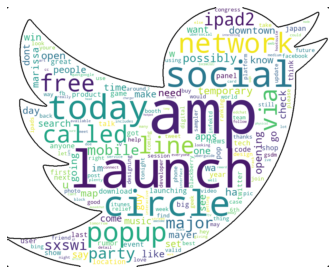

In [31]:
# Create wordcloud for neutral tweets for presentation
neut_word = df['stop_r'].loc[df['target'] == 'No emotion toward brand or product']
neut_text=" ".join(row for row in neut_word)
neut_freq = {}
for i in neut_text.split():
    if i in neut_freq:
        neut_freq[i] += 1
    else:
        neut_freq[i] = 1
neut_wordcloud = WordCloud(collocations=False, mask=mask,contour_width=2, background_color='white', width=1200, height=800).generate_from_frequencies(neut_freq) 
plt.imshow(neut_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout()
plt.show()

neut_wordcloud.to_file("./images/neut_cloud.png");

In [32]:
# Grab sample of a neutral tweet
df.loc[df['target']== 'No emotion toward brand or product']['tweet_text'].iloc[42]

"GSD&amp;M &amp; Google's Industry Party Tonight @mention - See u there! {link} #SXSW #Austin #Welivehere #GSDM"

#### Train Test Split
With our data processing complete, we performed a train-test split on the model using a 30% split between training and test data. We also performed vectorization of our training and test data in order to visualize how the data will be transformed in our pipeline. While we did not utilize these variables any further, it was helpful to visually inspect that the vectorizer worked correctly.


In [33]:
# Specify X as the cleaned strings in df['stop_r'] and y as the target sentiment.
X = df['stop_r']
y = df['target']

In [34]:
#Performed the train-test split, using 30% for the hold-out data.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.30)

In [35]:
# Instantiate and fit/transform X_train using the TF-IDF vectorizer.
tfidf = TfidfVectorizer(max_features=7000)
X_train_vectorized = tfidf.fit_transform(X_train)
X_train_vectorized

<6255x7000 sparse matrix of type '<class 'numpy.float64'>'
	with 47218 stored elements in Compressed Sparse Row format>

In [36]:
# Convert vectorized X_train to a vector for easier visual inspection.
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())
X_train_vec

,0310apple,100,100tc,103011p,1045am3,105hrs,10k,10mins,10x,10x2,...,ûïmute,ûïspecial,ûïspecials,ûïthe,ûïwin,ûòand,ûó,ûócan,ûólewis,ûóthe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# Transform test data using TF-IDF Vectorizer trained on X_train, y_train
X_test_vectorized = tfidf.transform(X_test)
X_test_vectorized

<2681x7000 sparse matrix of type '<class 'numpy.float64'>'
	with 18735 stored elements in Compressed Sparse Row format>

In [38]:
# Convert to DataFrame for visual inspection
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vectorized, columns=tfidf.get_feature_names())
X_test_vec

,0310apple,100,100tc,103011p,1045am3,105hrs,10k,10mins,10x,10x2,...,ûïmute,ûïspecial,ûïspecials,ûïthe,ûïwin,ûòand,ûó,ûócan,ûólewis,ûóthe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling
For our analysis, we elected to use accuracy score to evaluate our models. Our goal is to correctly categorize each tweet into positive, negative or neutral based on its contents. The multiclass nature of the problem makes it more challenging for the model to accurately predict sentiment. However, we chose accuracy as our evaluation metric because it evaluates how many of the model’s predictions are correct. The impact of a false negative or false positive prediction is less severe in this business case than in medical diagnosis, for example. Assuming that the accuracy performance of the model is good enough, the company should be able to use it to form a reasonable understanding of how the wider community is receiving their releases. It will be less suited for predicting the same for individual users, but that is not the goal of this analysis.

For each model we created a pipeline that includes a TF-IDF vectorizer, a smote component to deal with class imbalance, and the classifier itself. We elected to use a TF-IDF vectorizer instead of a count vectorizer because it provides a way to understand the importance of each word to the tweet, as well as just how frequently it occurs. 


In [39]:
# Define max features for all models
max_features = 7000

In [40]:
# Customer scorers using the weighted average argument, to be used in cross-validation

# Accuracy
accuracy = make_scorer(accuracy_score)

#f1
custom_f1 = make_scorer(
    f1_score, 
    average="weighted")

# Precision
multi_prec = make_scorer(
    precision_score,
    average="weighted")

# Recall
multi_rec = make_scorer(
    recall_score,
    average="weighted")

# This function will allow for quick cross-validation of the chosen score for each of our models.
def cross_val(model, X, y, custom_scorer, kfolds=5):
    """ Perform cross-validated scoring and store/print results """
    results = cross_val_score(model, X, y, cv=kfolds, scoring=custom_scorer)
    mean = np.mean(results)
    median = np.median(results)
    std = np.std(results)
    if custom_scorer == accuracy:
        print(f"Mean accuracy score: ", {mean}, ".")
        print(f"Median acuracy score: ", {median}, ".")
        print(f"Standard Deviation in accuracy: ", {std}, ".") 
    elif custom_scorer == custom_f1:
        print(f"Mean f1 score: ", {mean}, ".")
        print(f"Median f1 score: ", {median}, ".")
        print(f"Standard Deviation in f1 score: ", {std}, ".") 
    elif custom_scorer == multi_prec:
        print(f"Mean precision score: ", {mean}, ".")
        print(f"Median precision score: ", {median}, ".")
        print(f"Standard Deviation in precision score: ", {std}, ".") 
    elif custom_scorer == multi_rec:
        print(f"Mean recall score: ", {mean}, ".")
        print(f"Median recall score: ", {median}, ".")
        print(f"Standard Deviation in recall score: ", {std}, ".") 

### Dummy Classifier

We began with a dummy classifier to establish a baseline accuracy metric to meet. The dummy classifier simply guessed the most common class (neutral sentiment) for every observation. Due to the class imbalance, it performed relatively well with an accuracy score of 60.36%.

In [41]:
# Instantiate Dummy Classifier pipeline
dummy_pipe = ImPipeline(steps=[
                                    ('vect', TfidfVectorizer(max_features=max_features)),
                                    ('sm', SMOTE(random_state=42)),
                                    ('dc', DummyClassifier(strategy='constant', constant='No emotion toward brand or product',
                                                           random_state=42))
                                    ]
                            )

0.6036770583533173


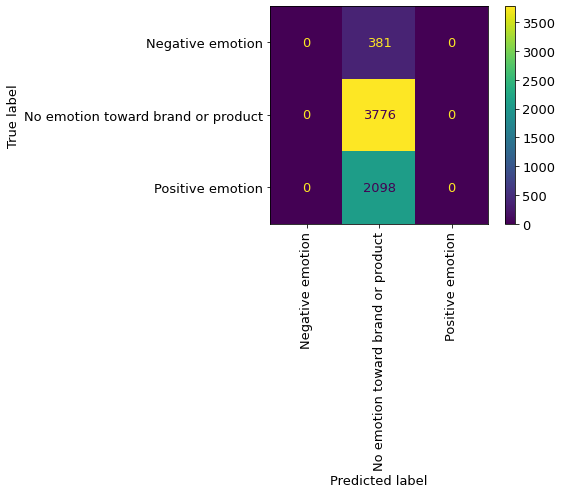

In [42]:
# Fit dummy pipe on the training data, get predictions and plot confusion matrix
dummy_pipe.fit(X_train, y_train)
dummy_yhat = dummy_pipe.predict(X_train)
plot_confusion_matrix(dummy_pipe, X_train, y_train, xticks_rotation=90);
print(accuracy_score(y_train, dummy_yhat))

In [43]:
# Show Classification Report
print(classification_report(y_train, dummy_yhat))

                                    precision    recall  f1-score   support

                  Negative emotion       0.00      0.00      0.00       381
No emotion toward brand or product       0.60      1.00      0.75      3776
                  Positive emotion       0.00      0.00      0.00      2098

                          accuracy                           0.60      6255
                         macro avg       0.20      0.33      0.25      6255
                      weighted avg       0.36      0.60      0.45      6255



C:\Users\John\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
# Obtained cross-validated accuracy score
cross_val(dummy_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.6036770583533173} .
Median acuracy score:  {0.6035171862509991} .
Standard Deviation in accuracy:  {0.0003197442046363186} .


### FSM - Logistic Regression
For our first simple model we chose a logistic regression model because it's relatively easy to implement and very efficient to train. The model performed better than the dummy classifier but only slightly, so we elected to continue our search for a better model.

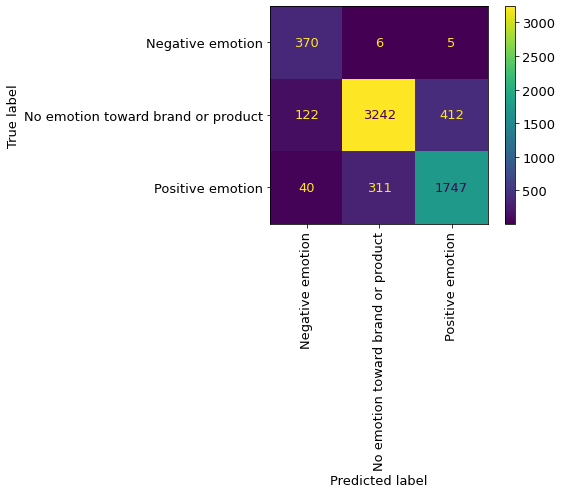

In [45]:
# Instantiate the Logistic Regression Pipeline
logreg_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('lr', LogisticRegression(max_iter=1000))
                                ]
                        )


# Fit Logistic Regression pipeline on the training data, get predictions and plot confusion matrix
logreg_pipe.fit(X_train, y_train)
logreg_yhat = logreg_pipe.predict(X_train)
plot_confusion_matrix(logreg_pipe, X_train, y_train, xticks_rotation=90);

In [46]:
# Show Classification Report
print(classification_report(y_train, logreg_yhat))

                                    precision    recall  f1-score   support

                  Negative emotion       0.70      0.97      0.81       381
No emotion toward brand or product       0.91      0.86      0.88      3776
                  Positive emotion       0.81      0.83      0.82      2098

                          accuracy                           0.86      6255
                         macro avg       0.80      0.89      0.84      6255
                      weighted avg       0.86      0.86      0.86      6255



In [47]:
# Obtained cross-validated accuracy score
cross_val(logreg_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.649400479616307} .
Median acuracy score:  {0.6418864908073542} .
Standard Deviation in accuracy:  {0.020003827107423867} .


### Multinomial Naive Bayes
Multinomial Naive Bayes is a commonly-used algorithm for natural language processing, so we chose it as our next model iteration. It typically does well on a dataset with categorical features, which we have, though it assumes there is independence between each pair of a feature. Surprisingly, the model performed worse than our baseline classifier, so we did not iterate on it further.

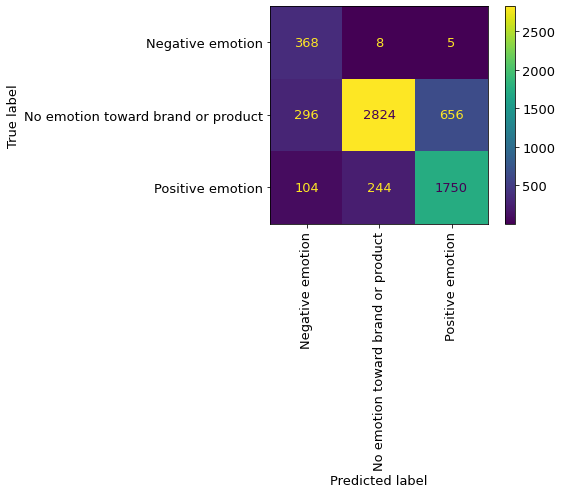

In [48]:
# Instantiate the MNB Pipeline
mnb_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('mnb', MultinomialNB())
                                ]
                        )

# Fit Multinomial Naive Bayes pipe on the training data, get predictions and plot confusion matrix
mnb_pipe.fit(X_train, y_train)
mnb_y_hat = mnb_pipe.predict(X_train)
plot_confusion_matrix(mnb_pipe, X_train, y_train, xticks_rotation=90);

In [49]:
# Show Classification Report
print(classification_report(y_train, mnb_y_hat))

                                    precision    recall  f1-score   support

                  Negative emotion       0.48      0.97      0.64       381
No emotion toward brand or product       0.92      0.75      0.82      3776
                  Positive emotion       0.73      0.83      0.78      2098

                          accuracy                           0.79      6255
                         macro avg       0.71      0.85      0.75      6255
                      weighted avg       0.83      0.79      0.80      6255



In [50]:
# Obtained cross-validated accuracy score
cross_val(mnb_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.597761790567546} .
Median acuracy score:  {0.5891286970423661} .
Standard Deviation in accuracy:  {0.01511954010236534} .


### Linear Support Vector
Support vector machines are another popular algorithm for nlp because they deal well with imbalanced data. In our case, the LSV model improved over all previous models, outperforming the dummy classifier by about five percentage points. Ultimately we chose not to iterate on it because we found other models that were more accurate.

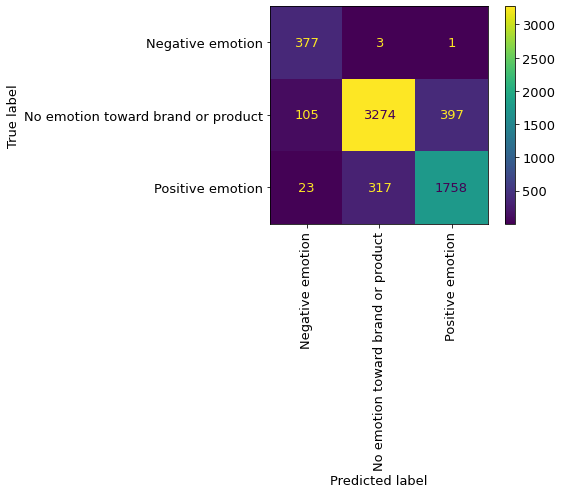

In [51]:
# Instantiate Linear Support Vector Pipeline
lsv_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('lsv', SGDClassifier(random_state=42))
                                ]
                        )

# Fit linear support vector machine on the training data, get predictions and plot confusion matrix
lsv_pipe.fit(X_train, y_train)
lsv_y_hat = lsv_pipe.predict(X_train)
plot_confusion_matrix(lsv_pipe, X_train, y_train, xticks_rotation=90);

In [52]:
# Show Classification Report
print(classification_report(y_train, lsv_y_hat))

                                    precision    recall  f1-score   support

                  Negative emotion       0.75      0.99      0.85       381
No emotion toward brand or product       0.91      0.87      0.89      3776
                  Positive emotion       0.82      0.84      0.83      2098

                          accuracy                           0.86      6255
                         macro avg       0.82      0.90      0.86      6255
                      weighted avg       0.87      0.86      0.87      6255



In [53]:
# Obtained cross-validated accuracy score
cross_val(lsv_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.6500399680255796} .
Median acuracy score:  {0.6442845723421263} .
Standard Deviation in accuracy:  {0.018502390099669794} .


### K-Nearest Neighbors
The model's ease of implementation and lack of training period made it an appealing early step. Unfortunately, the model's struggles with differentiating positive and neutral tweets ultimately made it unusable, but it was quite good at identifying negative emotions. 

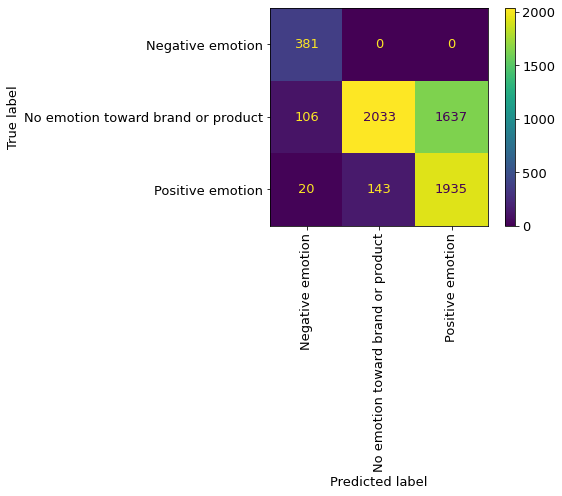

In [54]:
# Instantiate K-Nearest Neighbors pipeline
knn_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('knn', KNeighborsClassifier())  
                                ]
                        )

# Fit KNN pipeline on the training data, get predictions and plot confusion matrix
knn_pipe.fit(X_train, y_train)
knn_yhat = knn_pipe.predict(X_train)
plot_confusion_matrix(knn_pipe, X_train, y_train, xticks_rotation=90);

In [55]:
# Show Classification Report
print(classification_report(y_train, lsv_y_hat))

                                    precision    recall  f1-score   support

                  Negative emotion       0.75      0.99      0.85       381
No emotion toward brand or product       0.91      0.87      0.89      3776
                  Positive emotion       0.82      0.84      0.83      2098

                          accuracy                           0.86      6255
                         macro avg       0.82      0.90      0.86      6255
                      weighted avg       0.87      0.86      0.87      6255



In [56]:
# Obtained cross-validated accuracy score
cross_val(knn_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.5507593924860112} .
Median acuracy score:  {0.5579536370903277} .
Standard Deviation in accuracy:  {0.05515239970976967} .


### Gradient Boosting Classifier
The gradient boosting classifier was our sixth attempt at finding a model that would accurately predict sentiment in our data. Seeing the marginal results of the other models encouraged us to try a more complex model for our next step. Despite the model's added complexity, it too did not perform much better than any of our previous iterations. It struggled to differentiate between positive and neutral emotion, though it does perform noticeably better on the negative emotion class, correctly predicting 59% of the negative tweets as negative.

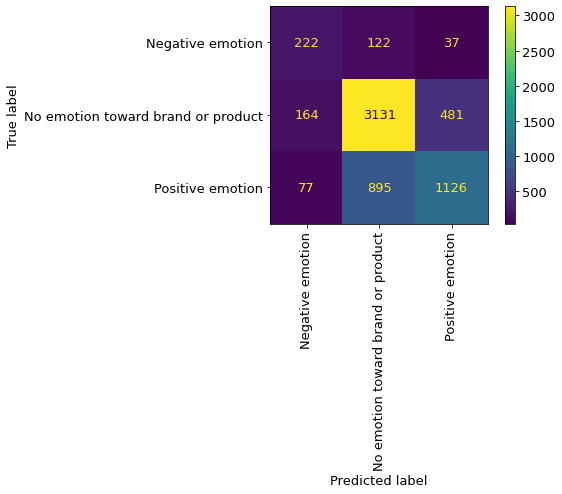

In [57]:
# Instantiate the pipeline
gbc_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('gbc',  GradientBoostingClassifier())
                                ]
                        )

# Fit gradient boosted pipeline on the training data, get predictions and plot confusion matrix
gbc_pipe.fit(X_train, y_train)
gbc_yhat = gbc_pipe.predict(X_train)
plot_confusion_matrix(gbc_pipe, X_train, y_train, xticks_rotation=90);

In [58]:
# Show Classification Report
print(classification_report(y_train, gbc_yhat))

                                    precision    recall  f1-score   support

                  Negative emotion       0.48      0.58      0.53       381
No emotion toward brand or product       0.75      0.83      0.79      3776
                  Positive emotion       0.68      0.54      0.60      2098

                          accuracy                           0.72      6255
                         macro avg       0.64      0.65      0.64      6255
                      weighted avg       0.71      0.72      0.71      6255



In [59]:
# Obtained cross-validated accuracy score
cross_val(gbc_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.6431654676258993} .
Median acuracy score:  {0.6458832933653078} .
Standard Deviation in accuracy:  {0.006286044205063942} .


### RF Classifier
The random forest classifier performed most accurately of all our models in classifying each of the 3 types of sentiment. It struggled with overfitting, as random forests are prone to do, but still produced the best accuracy score of any of the model types we tried. Based on its superior performance, we elected to tune its hyperparameters to see how far we could push the accuracy using our training data.

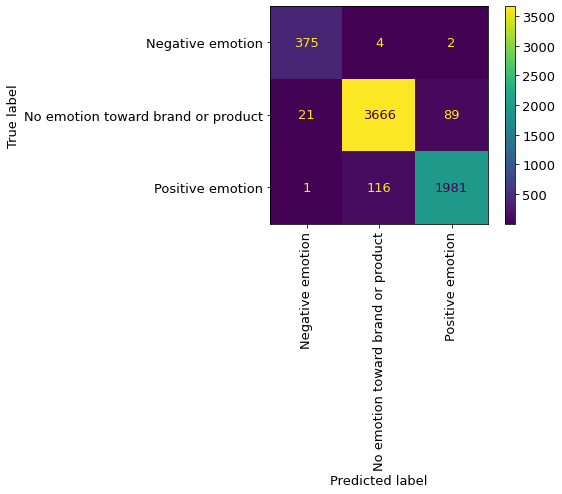

In [60]:
# Instantiate Random Forest pipeline
rf_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('rf', RandomForestClassifier(random_state=42))
                                ]
                        )

# Fit random forest pipeline on the training data, get predictions and plot confusion matrix
rf_pipe.fit(X_train, y_train)
rfp_yhat = rf_pipe.predict(X_train)
plot_confusion_matrix(rf_pipe, X_train, y_train, xticks_rotation=90);

In [61]:
# Show Classification Report
print(classification_report(y_train, rfp_yhat))

                                    precision    recall  f1-score   support

                  Negative emotion       0.94      0.98      0.96       381
No emotion toward brand or product       0.97      0.97      0.97      3776
                  Positive emotion       0.96      0.94      0.95      2098

                          accuracy                           0.96      6255
                         macro avg       0.96      0.97      0.96      6255
                      weighted avg       0.96      0.96      0.96      6255



In [62]:
# Obtained cross-validated accuracy score
cross_val(rf_pipe, X_train, y_train, accuracy)

Mean accuracy score:  {0.6740207833733013} .
Median acuracy score:  {0.6802557953637091} .
Standard Deviation in accuracy:  {0.018722108532754494} .


#### Gridsearch--Random Forest

In [63]:
# Print out original parameters of rf classifier in rf_pipe
print('Current Parameters:\n')
pprint(rf_pipe.named_steps['rf'].get_params())

Current Parameters:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [64]:
# Define new set of parameters to grid-search over
rf_params = {
            'rf__n_estimators': [100, 250, 500, 1000],
            'rf__criterion': ['gini', 'entropy'],
            'rf__min_samples_leaf': [1, 2, 3],
            'rf__min_samples_split': [2, 4, 5, 6],
            'rf__max_depth': [100, 200, 300],
            'rf__bootstrap': [True, False],
            'vect__max_features': [None, 2000, 4000, 5000, 6000, 7000]
             }

# Instantiate grid search object using parameters defined above.
#rf_gs = GridSearchCV(rf_pipe, param_grid=rf_params, n_jobs=-2, verbose=3, cv=3)

# Fit the grid search object on training data
#rf_gs.fit(X_train, y_train)

# Output the best parameters based on the grid search
#rf_gs.best_params_

grid search 1 params = 
- 'rf__n_estimators': [25, 50, 100, 250],
- 'rf__criterion': ['gini', 'entropy'],
- 'rf__min_samples_leaf': [1, 2],
- 'rf__min_samples_split': [2, 5, 10],
- 'rf__max_depth': [None, 25, 50, 100],
- 'rf__bootstrap': [True, False],
- 'vect__max_features': [None, 4000, 2000, 1000]
             
gridsearch 1 output: 
- {'rf__bootstrap': True,
- 'rf__criterion': 'entropy',
- 'rf__max_depth': None,
- 'rf__min_samples_leaf': 1,
- 'rf__min_samples_split': 5,
- 'rf__n_estimators': 250,
- 'vect__max_features': None}

grid search 2 params = 
- 'rf__n_estimators': [200, 250, 300],
- 'rf__criterion': ['gini', 'entropy'],
- 'rf__min_samples_leaf': [1, 2],
- 'rf__min_samples_split': [4, 5, 6],
- 'rf__max_depth': [None, 100, 150, 200],
- 'rf__bootstrap': [True, False],
- 'vect__max_features': [None, 6000, 8000]
             

grid search 2 output:
- {'rf__bootstrap': True,
- 'rf__criterion': 'gini',
- 'rf__max_depth': 200,
- 'rf__min_samples_leaf': 1,
- 'rf__min_samples_split': 6,
- 'rf__n_estimators': 250,
- 'vect__max_features': 6000}s

grid search 3 params = 
- 'rf__n_estimators': [225, 250, 275],
- 'rf__criterion': ['gini', 'entropy'],
- 'rf__min_samples_leaf': [1, 2],
- 'rf__min_samples_split': [5, 6, 7],
- 'rf__max_depth': [150, 200, 300],
- 'rf__bootstrap': [True, False],
- 'vect__max_features': [5000, 6000, 7000]

grid search 3 output:
- {'rf__bootstrap': True,
- 'rf__criterion': 'gini',
- 'rf__max_depth': 200,
- 'rf__min_samples_leaf': 1,
- 'rf__min_samples_split': 5,
- 'rf__n_estimators': 250,
- 'vect__max_features': 5000}

grid search 4 params = 
- 'rf__n_estimators': [240, 250, 260],
- 'rf__criterion': ['gini', 'entropy'],
- 'rf__min_samples_leaf': [1, 2],
- 'rf__min_samples_split': [4, 5, 6],
- 'rf__max_depth': [190, 200, 210],
- 'rf__bootstrap': [True, False],
- 'vect__max_features': [None, 4500, 5000, 5500, 6000]

grid search 4 output:
- {'rf__bootstrap': True,
- 'rf__criterion': 'gini',
- 'rf__max_depth': 200,
- 'rf__min_samples_leaf': 1,
- 'rf__min_samples_split': 5,
- 'rf__n_estimators': 250,
- 'vect__max_features': 5000}

grid search 5 params =
- 'rf__n_estimators': [100, 250, 500, 1000],
- 'rf__criterion': ['gini', 'entropy'],
- 'rf__min_samples_leaf': [1, 2, 3],
- 'rf__min_samples_split': [2, 4, 5, 6],
- 'rf__max_depth': [100, 200, 300],
- 'rf__bootstrap': [True, False],
- 'vect__max_features': [None, 2000, 4000, 5000, 6000, 7000]


grid search 5 output:
- {'rf__bootstrap': True,
- 'rf__criterion': 'gini',
- 'rf__max_depth': 200,
- 'rf__min_samples_leaf': 1,
- 'rf__min_samples_split': 5,
- 'rf__n_estimators': 250,
- 'vect__max_features': 5000}

Our 5th grid search produced a cross-validated accuracy score that was better, though not much improved from any of our prior iterations. With a final score of 68.2%, we chose to use the random forest classifier as our final model.

#### Model Performance Visualization

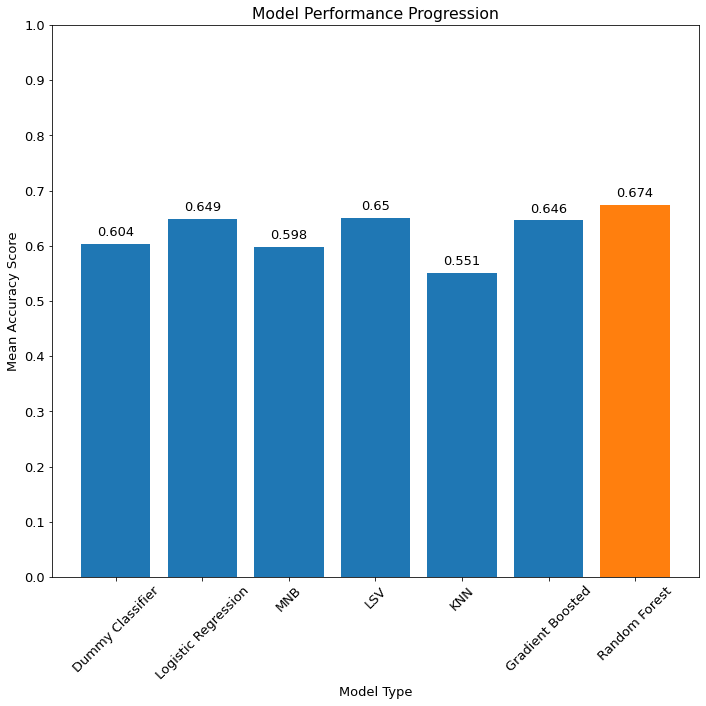

In [65]:
# Create dictionary of models and cross-val scores
model_its = {'Dummy Classifier':0.604, 'Logistic Regression':0.649, 'MNB':0.598, 'LSV': 0.65, 'KNN':0.551, 'Gradient Boosted':0.646, 'Random Forest':0.674}

# Plot bar graph using model_its dictionary
plt.rcParams.update({'font.size': 13});
colors = ["C1" if i > 0.66 else 'C0' for i in model_its.values()]
fig, ax = plt.subplots(figsize=(10,10))
pps = plt.bar(x = model_its.keys(), height=model_its.values(), color=colors)

plt.xlabel('Model Type')
plt.ylabel('Mean Accuracy Score')
plt.title('Model Performance Progression')
plt.xticks(rotation = 45)
plt.yticks(np.arange(0, 1.1, step=0.1))

# Assign score values to each bar in the graph
for p in pps:
   height = p.get_height()
   ax.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height),
      xytext=(0, 5), # 3 points vertical offset
      textcoords="offset points",  
      ha='center', va='bottom')
plt.tight_layout();

plt.savefig('./images/mod_perf', facecolor='white', dpi=500)

# Final Model & Evaluation

With an accuracy score on the test data of 62%, our final model is performing better than the baseline on unseen data. There is a great deal of room for improvement however, as it struggles heavily with correctly identifying negative sentiment. The model only identified 21% of negative tweets correctly in our test data, and only 46% of positive tweets in the test data. Its superior accuracy score is due largely to its success in accurately classifying neutral tweets as neutral. With more than 60% of the dataset comprised of neutral tweets, the success in predicting that class outweighs its poor performance with tweets that express emotion. 

Given the class imbalance present in the dataset, it is likely that the model doesn't have enough examples of negative sentiment to perform well. This could be improved with a larger (or at minimum, more balanced) dataset. In order to be useful for classifying new tweets, the model would need to significantly reduce or ideally eliminate the need for a human to manually check its work. Our model accomplishes that with a 62% accurate rate, but still leaves quite a bit of room for error and therefore creates a requirement for manual follow-up. Further tuning of the model's hyperparameters are unlikely to produce significant improvement, meaning that more data (and specifically more negative data) is needed to improve the model's results.

If no further data can be reasonably obtained for training, a practical use of the model could be to separate future tweets into groups of "neutral" and "needing review". The "needing review" class could then be labeled by a human or fed to a binary classifier that might have success identifying them as positive or negative. 

We visualized the final model's performance with a confusion matrix and a graph of the accurace scores when grouped by class.

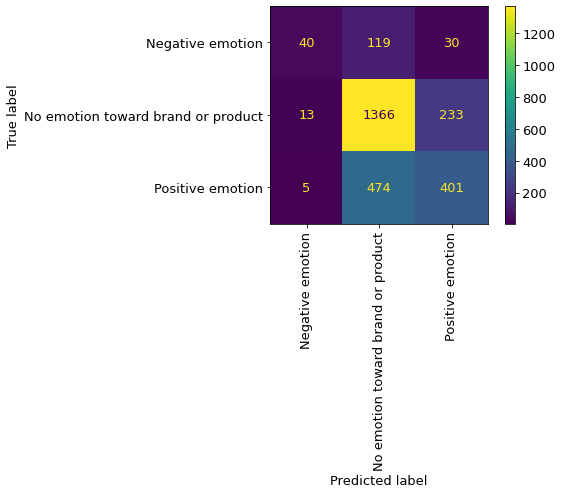

In [66]:
# Instantiate a random forest pipeline using optimal parameters based on the grid search
final_pipe = ImPipeline(steps=[
                                 ('vect', TfidfVectorizer(max_features=max_features)),
                                 ('sm', SMOTE(random_state=42)),
                                 ('rf', RandomForestClassifier(
                                     bootstrap= True,
                                     criterion='gini',
                                     max_depth=200,
                                     min_samples_leaf=1,
                                     min_samples_split=5,
                                     n_estimators=250,
                                     random_state=42))
                                ]
                        )

# Fit final model pipeline on the training data, get predictions from test data and plot confusion matrix
final_pipe.fit(X_train, y_train)
plot_confusion_matrix(final_pipe, X_test, y_test, xticks_rotation=90);

In [67]:
# Obtained cross-validated accuracy score on test data
cross_val(final_pipe, X_test, y_test, accuracy)

Mean accuracy score:  {0.6266398454654103} .
Median acuracy score:  {0.6436567164179104} .
Standard Deviation in accuracy:  {0.029446986484444947} .


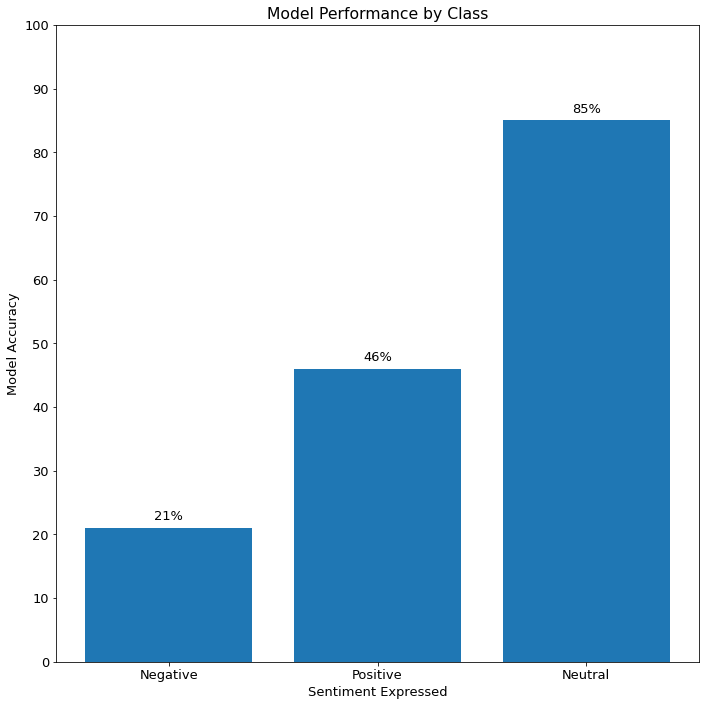

In [68]:
# Create dictionary of Sentiments & accurate predictions
sent_perc = {"Negative": 21, "Positive": 46, "Neutral": 85}

# Plot bar graph of accuracy performance by sentiment
plt.rcParams.update({'font.size': 13});
fig, ax = plt.subplots(figsize=(10,10))
pps = plt.bar(x = sent_perc.keys(), height=sent_perc.values(), color=colors)

# Define axis labels, model title, and configure ticks
plt.xlabel('Sentiment Expressed')
plt.ylabel('Model Accuracy')
plt.title('Model Performance by Class')
plt.yticks(np.arange(0, 101, step=10))

# Assign accuracy score values to each bar in the graph
for p in pps:
    height = p.get_height()
    ax.annotate('{}%'.format(height),
        xy=(p.get_x() + p.get_width() / 2, height),
        xytext=(0, 5), 
        textcoords="offset points",  
        ha='center', va='bottom')
plt.tight_layout();

plt.savefig('./images/final_sentiment_perf', facecolor='white', dpi=500)

# Conclusion

Our model correctly classified tweet sentiment 62% of the time on unseen data. The other 38% of the time, it misclassified a positive, negative or neutral tweet as one of the other sentiments. It struggled the most with negative sentiment, which makes sense given the class imbalance present in the data. With relatively few examples of negative language, it is hard for the model to pick up on what makes a negative tweet negative. A first step in improving the model's performance could be to provide additional examples of negative sentiment tweets for further training of the model.

### Recommendations & Next Steps

**Persistent Training** <br>
The dataset we trained on is relatively small for an nlp project, and could be improved by continual training and improvement of the model. Given that tweets are so easy to compose, it should be possible to get new data points nearly every day. Twitter's api makes these accessible and the preprocessing can be performed with relative ease using the code herein. One might also argue that because tweets are so easy to write, you are more likely to capture a person's thoughts when they are feeling emotional about something. It's much easier to post a tweet in the heat of the moment than to sit down and write a longer blog post or essay to tease out one's emotions. That can be a double-edged sword however, because of Twitter’s character limit. With a small number of characters, not everyone can easily convey nuanced emotion. If simple words are duplicated across all sentiment classes, they start to lose their meaning to the model. 

**Source Data from Additional Social Media Applications** <br>
The company's own BaceFook posts are a logical place to start, but reddit is another example that might prove fruitful due to its ability to accommodate longer posts. With a greater variety of language in each sentiment class, the model will be better able to differentiate between positive, negative and neutral emotion.

**Investigate More Advanced Models** <br>
If the company is willing to spend up for distributed computing, we would recommend applying a neural network model to the task. There are many pre-trained sentiment analysis algorithms that we could tune using our dataset that might produce superior results. The downside of course is paying for the implementation in a cloud platform. Still, BaceFook might see benefit if model performance can be improved to the point that it eliminates the need for a human to spot-check its work.